In [27]:
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

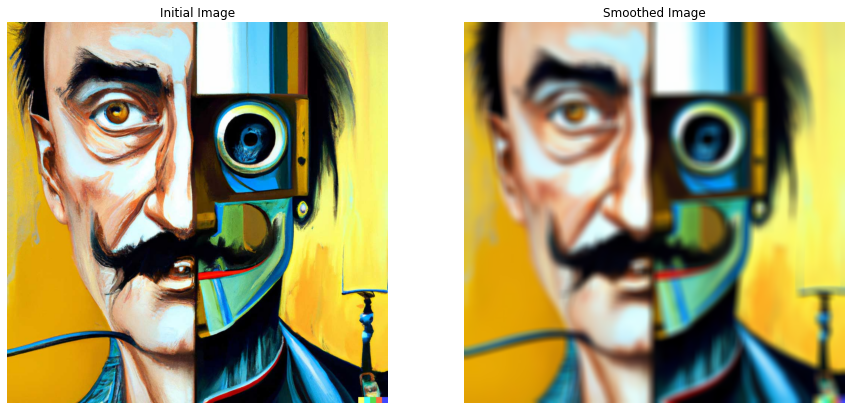

In [84]:
dalle = cv2.imread('dalle.jpg', cv2.IMREAD_COLOR)[:, :, ::-1] / 255
dalle = dalle.astype(np.float32)
smoothed_dalle = cv2.GaussianBlur(dalle, (25, 25), 20)

fig = plt.figure(figsize=(15, 10))
ax0 = plt.subplot(1, 2, 1)
ax0.set_title('Initial Image')
ax0.axis('off')
ax0.imshow(dalle)

ax1 = plt.subplot(1, 2, 2)
ax1.set_title('Smoothed Image')
ax1.axis('off')
ax1.imshow(smoothed_dalle)

In [164]:
def nonadaptive_unsharp(img):
    filter_ = np.array([[-1, -2, -1],
                       [-2, 12, -2],
                       [-1, -2, -1]]) / 16

    output = np.zeros_like(img)
    for i in range(output.shape[-1]):
        output[:, :, i] = signal.convolve2d(img[:, :, i], filter_, mode='same')

    output = (output - output.min()) / (output.max() - output.min())
    output = 50 * output + img - 1
    
    output[output > 1] = 1
    output[output < 0] = 0
    return output

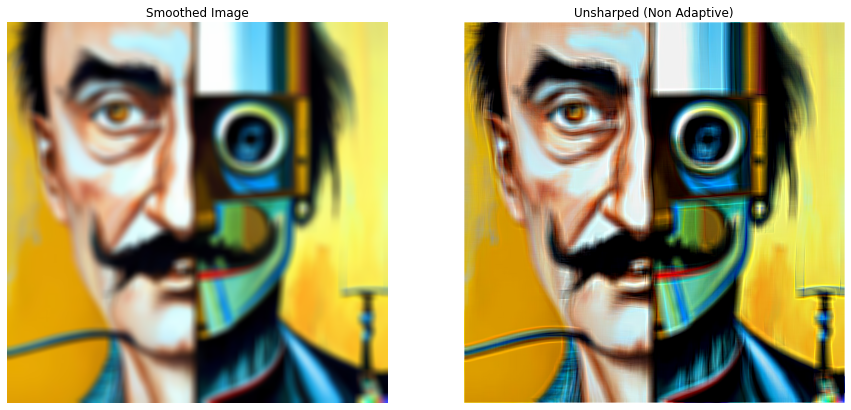

In [165]:
unsharped_nonadap = nonadaptive_unsharp(smoothed_dalle)

fig = plt.figure(figsize=(15, 10))
ax0 = plt.subplot(1, 2, 1)
ax0.set_title('Smoothed Image')
ax0.axis('off')
ax0.imshow(smoothed_dalle)

ax1 = plt.subplot(1, 2, 2)
ax1.set_title('Unsharped (Non Adaptive)')
ax1.axis('off')
ax1.imshow(unsharped_nonadap)

In [239]:
def adaptive_unsharp(img, t):
    
    f = np.array([
                    [
                        [0, 0, 0],
                        [-2, 2, 0],
                        [0, 0, 0]
                    ],
                    [
                        [-1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]
                    ],
                    [
                        [0, -2, 0],
                        [0, 2, 0],
                        [0, 0, 0]
                    ],
                    [
                        [0, 0, -1],
                        [0, 1, 0],
                        [0, 0, 0]
                    ],
                    [
                        [0, 0, 0],
                        [0, 2, -2],
                        [0, 0, 0]
                    ],
                    [
                        [0, 0, 0],
                        [0, 1, 0],
                        [0, 0, -1]
                    ],
                    [
                        [0, 0, 0],
                        [0, 2, 0],
                        [0, -2, 0]
                    ],
                    [
                        [0, 0, 0],
                        [0, 1, 0],
                        [-1, 0, 0]
                    ]
    ])

    output = np.zeros_like(img)

    for i in range(output.shape[-1]):
        for j in range(f.shape[0]):
            filter_ = f[j, :, :]
            this_output = signal.convolve2d(img[:, :, i], filter_, mode='same')
            this_output[this_output < t] = 0
            output[:, :, i] += this_output

    output = (output - output.min()) / (output.max() - output.min())
    output = 50 * output + img - 0.2

    # output = output * 50
    output[output > 1] = 1
    output[output < 0] = 0
    return output

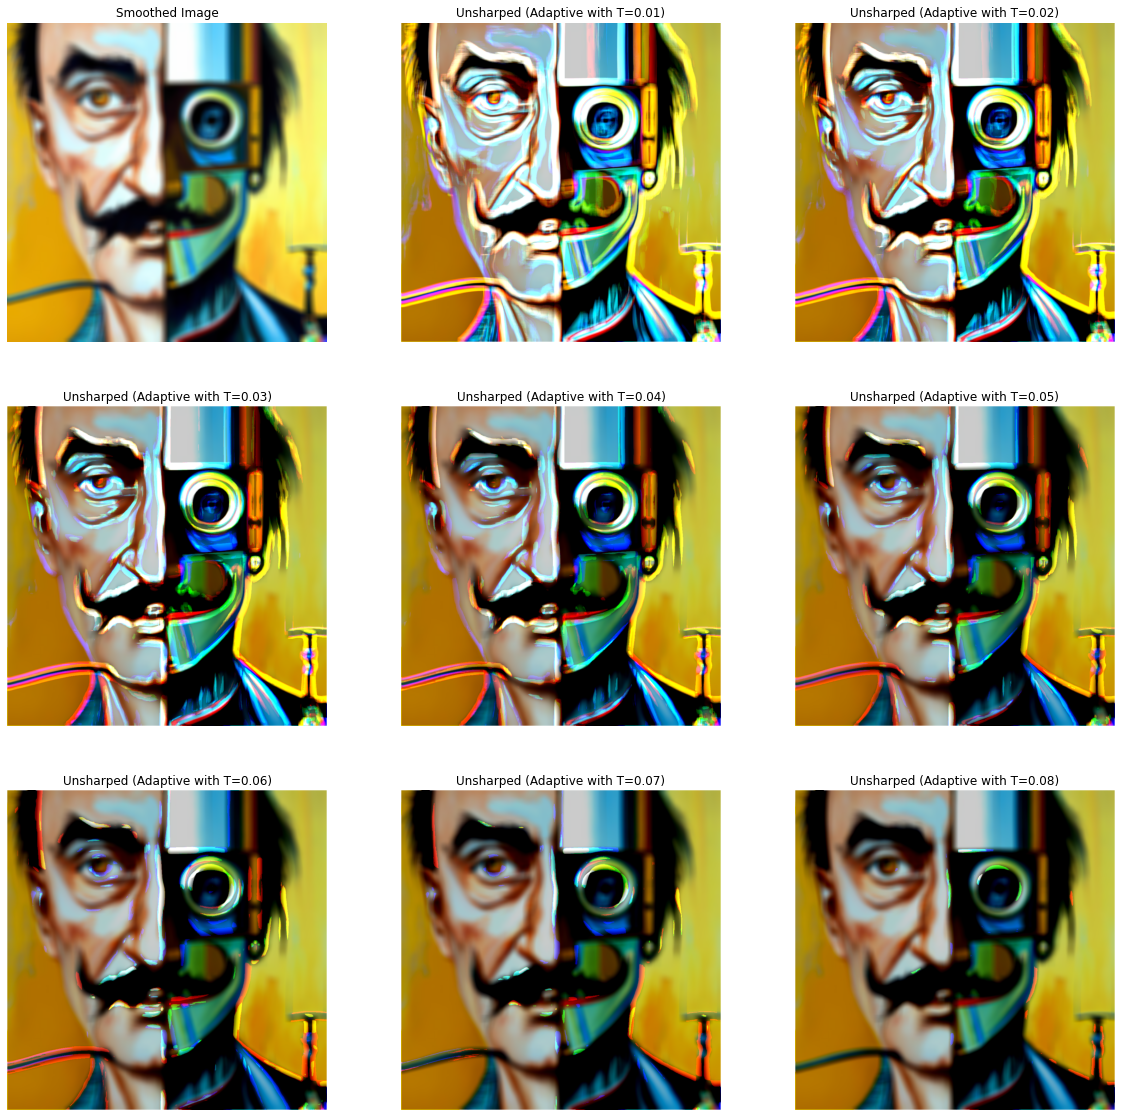

In [241]:
thresholds = np.arange(0.01, 0.08, 0.01)

fig = plt.figure(figsize=(20, 20))
ax0 = plt.subplot(3, 3, 1)
ax0.set_title('Smoothed Image')
ax0.axis('off')
ax0.imshow(smoothed_dalle)

for i, t in enumerate(thresholds):
    unsharped_adap = adaptive_unsharp(smoothed_dalle, t)
    ax = plt.subplot(3, 3, i+2)
    ax.set_title(f'Unsharped (Adaptive with T={t:.2f})')
    ax.axis('off')
    ax.imshow(unsharped_adap)